In this workshop, we will be using Keras with TensorFlow backend to train a digits classifier uisng MNIST dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## for working on multi-user GPU station
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# config.gpu_options.visible_device_list = "2"
# set_session(tf.Session(config=config))

### load data
Keras provides API to download MNIST dataset

In [2]:
from keras.datasets import mnist

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# this line of code will download the data in the backend and store the data in your system automatically. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print('x_train shape: {}; y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_test shape: {}; y_test shape: {}'.format(x_test.shape, y_test.shape))

x_train shape: (60000, 28, 28); y_train shape: (60000,)
x_test shape: (10000, 28, 28); y_test shape: (10000,)


In [5]:
def data_visualize(images, labels, n_rows=3, n_cols=3):
    f, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*3, n_cols*3))
    for axe in axes:
        for axe_plot in axe:
            i = np.random.randint(0, len(images))
            axe_plot.imshow(images[i], cmap='gray')
            axe_plot.set_title(labels[i])

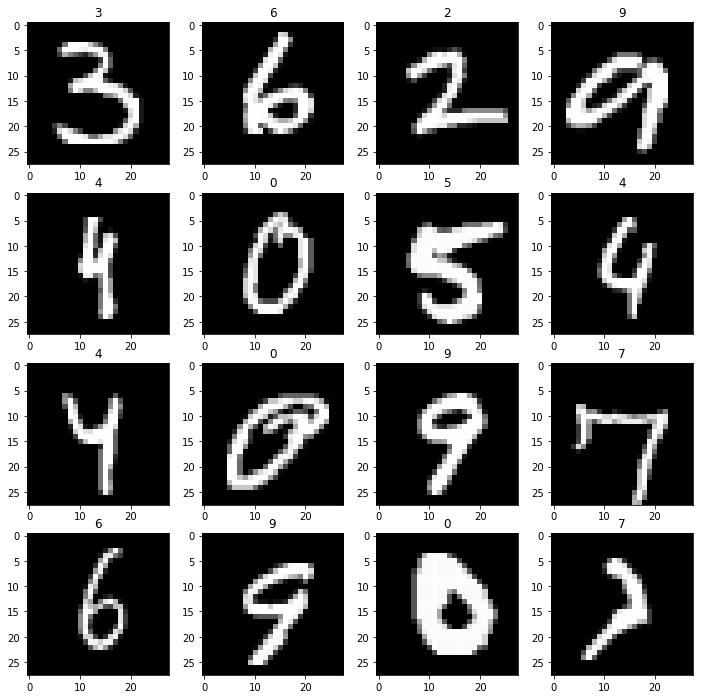

In [6]:
data_visualize(x_train, y_train, 4, 4)

### prepare data for training

In [7]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) # (batch_size, height, width, channels)

y_train = to_categorical(y_train) # one-hot encoding


In [8]:
# divide into training, validation, test split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

In [9]:
print('x_train shape: {}; y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_validation shape: {}; y_validation shape: {}'.format(x_val.shape, y_val.shape))
print('x_test shape: {}; y_test shape: {}'.format(x_test.shape, y_test.shape))

x_train shape: (48000, 28, 28, 1); y_train shape: (48000, 10)
x_validation shape: (12000, 28, 28, 1); y_validation shape: (12000, 10)
x_test shape: (10000, 28, 28); y_test shape: (10000,)


### build model

In [10]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [11]:
n_classes = 10
# hyperparameters
epochs = 10
batch_size = 32

In [12]:
def get_model(input_shape):
    
    drop = 0.3
    # l2 regularization as well as dropout can help prevent overfitting
    l2_reg = regularizers.l2(0.01)
    
    X_input = Input(input_shape)
    X = BatchNormalization()(X_input) # normalize input 
    
    X = Conv2D(8, (3,3), strides=(1,1), activation='relu',
               kernel_regularizer=l2_reg,
               kernel_initializer='glorot_normal')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(16, (3,3), strides=(2,2), activation='relu',
               kernel_regularizer=l2_reg,
               kernel_initializer='glorot_normal')(X)
    X = MaxPooling2D((2,2))(X)    
    
    X = Conv2D(32, (2,2), strides=(1,1), activation='relu',
               kernel_regularizer=l2_reg,
               kernel_initializer='glorot_normal')(X)
    
    X = MaxPooling2D((2,2))(X)
    
    X = Flatten()(X)
    
    X = BatchNormalization()(X)
    X = Dense(128, activation='relu')(X)
    X = Dropout(drop)(X)
    
#     X = Dense(32, activation='relu')(X)
#     X = Dropout(0.1)(X)
    
#     X = Dense(16, activation='relu')(X)
# #     X = Dropout(drop)(X)    
    
    X = Dense(10, activation='softmax')(X)
    
    model = Model(inputs=[X_input], outputs=[X])
    
    return model

In [13]:
model = get_model((28,28,1))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 16)          1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 32)          2080      
__________

In [15]:
# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# training
f_path = 'model.h5'
msave = ModelCheckpoint(f_path, save_best_only=True)

In [17]:
training = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     epochs=epochs,
                     callbacks = [msave],
                     batch_size=batch_size, 
                     verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 55s 1ms/step - loss: 0.5655 - acc: 0.8806 - val_loss: 0.3388 - val_acc: 0.9304
Epoch 2/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.2373 - acc: 0.9548 - val_loss: 0.2524 - val_acc: 0.9437
Epoch 3/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1874 - acc: 0.9635 - val_loss: 0.2374 - val_acc: 0.9422
Epoch 4/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1616 - acc: 0.9686 - val_loss: 0.1413 - val_acc: 0.9716
Epoch 5/10
48000/48000 [==============================] - 54s 1ms/step - loss: 0.1538 - acc: 0.9693 - val_loss: 0.2297 - val_acc: 0.9432
Epoch 6/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1472 - acc: 0.9697 - val_loss: 0.1736 - val_acc: 0.9621
Epoch 7/10
48000/48000 [==============================] - 53s 1ms/step - loss: 0.1443 - acc: 0.9712 - val_loss: 0.2708 - val_acc

### visualize training results

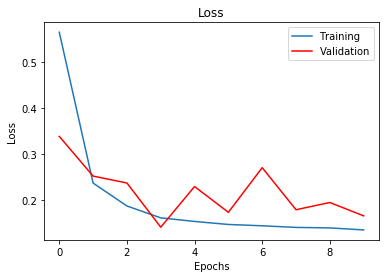

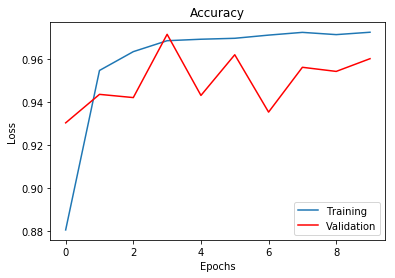

In [18]:
# show the loss and accuracy
loss = training.history['loss']
val_loss = training.history['val_loss']
acc = training.history['acc']
val_acc = training.history['val_acc']

# loss plot
tra = plt.plot(loss)
val = plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

plt.show()

# accuracy plot
plt.plot(acc)
plt.plot(val_acc, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.legend(['Training', 'Validation'], loc=4)
plt.show()

### model evaluation on test set

In [19]:
X_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
from sklearn.metrics import accuracy_score
model = load_model(f_path)
pred = model.predict(X_test)
# convert predicions from categorical back to 0...9 digits
pred_digits = np.argmax(pred, axis=1)

accuracy_score(y_test, pred_digits)

0.9711

### visualize prediction

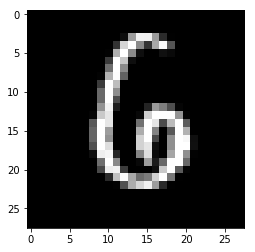

In [20]:
i = np.random.randint(0, len(x_test))
test_img = x_test[i]
plt.imshow(test_img, cmap='gray')


In [21]:
def predict(imgs, model):
    if imgs.shape == (28,28):
        imgs = imgs.reshape((1, 28, 28, 1))
    else:
        imgs = imgs.reshape((imgs.shape[0], 28, 28, 1))
    
    preds = model.predict(imgs)
    return np.argmax(preds, axis=1)

In [22]:
predict(test_img, model)[0]

6

In [23]:
def visual_preds(test_imgs, test_labels, model):
    f, axes = plt.subplots(nrows=4, ncols=4, figsize=(9, 13))
    for axe in axes:
        for axe_plot in axe:
            i = np.random.randint(0, len(test_imgs))
            axe_plot.imshow(test_imgs[i], cmap='gray')
            axe_plot.set_title('pred: {}; truth: {}'.format(predict(test_imgs[i], model)[0], test_labels[i]))

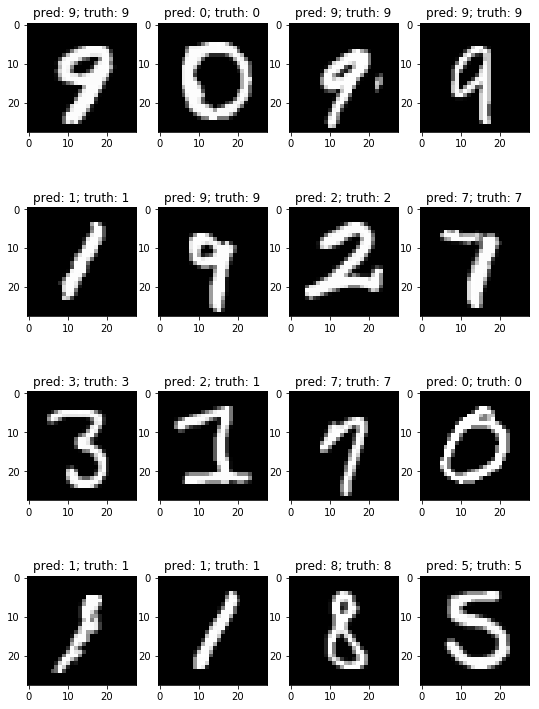

In [24]:
visual_preds(x_test, y_test, model)